# Coding Assignment 5: Support Vector Machine Classifier

CS 598 Practical Statistical Learning

2023-11-27

UIUC Fall 2023

**Authors**
* Ryan Fogle
    - rsfogle2@illinois.edu
    - UIN: 652628818
* Sean Enright
    - seanre2@illinois.edu
    - UIN: 661791377

**Contributions**

Ryan provided the initial implementation of the Pegasos algorithm, as well as the initial data cleaning, confusion matrices and test results.

Sean refactored the Pegasos algorithm implementation to vectorize operations, cleaned up the relabeling of data and added markdown to explain steps of the process.

## Introduction

In this assignment, we implement a Support Vector Machine (SVM) classifier using the Pegasos (Primal Estimated sub-GrAdient SOlver for SVM) algorithm. The Pegasos algorithm itself optimizes SVM parameters using stochastic gradient descent (SGD).

To validate our implementation, we classify two digits of the MNIST dataset.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## The Pegasos Algorithm

The learning problem for a SVM can be stated as the following minimization problem:
$$
\min_{\beta, \alpha}
\frac{\lambda}{2} \lVert \beta \rVert^2
+ \frac{1}{n} \sum_{i=1}^{n} \left [ 1 - y(x^t \beta + \alpha) \right ]_{+}
$$

In the Pegasos algorithm, this objective function $J$ is iteratively approximated with samples of the training set observations as follows.

$$
J_i(\beta, \alpha) = 
\frac{\lambda}{2} \lVert \beta \rVert^2
+ \frac{1}{n} \sum_{i=1}^{n} \left [ 1 - y_i(x_i^t \beta + \alpha) \right ]_{+}
$$

where $\alpha$ is the intercept and $\beta$ is the p-dimensional coefficient vector.

These two parameters are updated iteratively by using their subgradients to approach a local optimum. These subgradients are

$$
\Delta_t =
\begin{cases}
    \lambda \beta_t - y_i x_i & \text{if} y_i(x_i^t \beta_t + \alpha_t) < 1 \\
    \lambda \beta_t           & \text{otherwise} \\
\end{cases}
$$

$$
\delta_t =
\begin{cases}
    -y_i & \text{if} y_i(x_i^t \beta_t + \alpha_t) < 1 \\
    0    & \text{otherwise} \\
\end{cases}
$$

where $\Delta_t$ and $\delta_t$ are the subgradients at iteration $t$ with respect to $\beta$ and $\alpha$, respectively.

The Pegasos algorithm can be summarized as follows:

1. initialize $\beta = 0_{p \times 1}$, $\alpha_1 = 0$, and $t=0$
2. for epoch = $1, 2, ..., T$, do
    * for $i = 1, 2, …, n$, do
        * $t = t + 1$
        * $\eta_t = \frac{1}{t \, \lambda}$
        * $\beta_{t+1} \Leftarrow \beta_t - \eta_t \, \Delta_t$
        * $\alpha_{t+1} \Leftarrow \alpha_t - \eta_t \, \delta_t$

In [2]:
def pegasos(x, y, epochs=20, lam=1):

    # Intialize parameters
    beta  = np.zeros(x.shape[1])
    alpha = 0
    t     = 1
    n     = y.shape[0]
    
    for epoch in range(epochs):
        # Shuffle data
        inds = np.arange(n)
        np.random.shuffle(inds)
        x = x[inds]
        y = y[inds]

        # eta is vectorized, using t values that increase for each observation
        eta = (1 / (lam * np.arange(t, t + n))).reshape(-1, 1)

        # in_margin: support vectors
        in_margin = (y * np.squeeze(x @ beta.reshape(-1, 1) + alpha)) < 1

        # Beta (big delta) subgradient:
        beta_grad = np.empty(x.shape)
        beta_grad[in_margin] = lam * beta - y[in_margin].reshape(-1, 1) * x[in_margin, :]
        beta_grad[~in_margin] = lam * beta
        beta_grad = (eta * beta_grad).sum(axis=0)
        
        # Alpha (little delta) subgradient
        alpha_grad = np.empty(y.shape)
        alpha_grad[in_margin]  = -y[in_margin]
        alpha_grad[~in_margin] = 0
        alpha_grad = (eta * alpha_grad).sum(axis=0)[0]

        # Update beta, alpha and t
        beta -= beta_grad
        alpha -= alpha_grad
        t += n
    return beta, alpha

## Data

To train a SVM and validate its classification ability, a subset of the MNIST dataset is used. 200 training samples and 600 test samples are used. Only observations with the labels "5" and "6" are used.

In [3]:
# set random seed
np.random.seed(3434)

# Read in data
train = pd.read_csv('coding5_train.csv')
test = pd.read_csv('coding5_test.csv')

# Create Data matrixes
train_x = train[train.columns[:-1]].copy().values
train_y = train['Y'].copy().values
test_x = test[test.columns[:-1]].copy().values
test_y = test['Y'].copy().values

Our SVM expects the labels to be either $-1$ or $1$, so we relabel the MNIST data accordingly:
* $5$ (`class_a`) is relabeled as $-1$
* $6$ (`class_b`) is relabled as $1$

In [4]:
class_a = 5
class_b = 6
train_y_relabeled = np.where(train_y == class_a, -1, 1)
test_y_relabeled  = np.where(test_y  == class_b, -1, 1)

## Results

To validate our SVM implementation, we present confusion tables for the training and test datasets, as well as test error.

### Training

The SVM is trained on the test partition for $T=20$ epochs with $\lambda=1$.

In [5]:
num_epoch = 20
lam       = 1  # lambda hyperparameter

beta, alpha = pegasos(x=train_x, y=train_y_relabeled, epochs=num_epoch, lam=lam)

## Predictions
Here we generate predictions $\hat{y}$ by

$$
\hat{y} =
\begin{cases}
0 &  x^t \beta + \alpha < 0 \\
1 &  x^t \beta + \alpha > 0 \\
\end{cases}
$$

and relabel the predictions as label "5" or "6" accordingly.

Predictions are made for the training and test datasets.

In [6]:
# Training dataset
train_y_pred = train_x @ beta.T + alpha
train_y_pred = np.where(train_y_pred < 0, class_a, class_b)

# Test dataset
test_y_pred = test_x @ beta.T + alpha
test_y_pred = np.where(test_y_pred < 0, class_a, class_b)

## Confusion Matrices

### Training Dataset

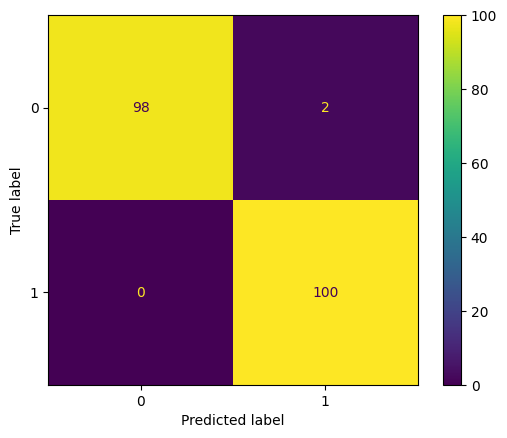

In [7]:
fig = ConfusionMatrixDisplay(confusion_matrix(train_y, train_y_pred))
fig.plot()
plt.show()

### Test Dataset

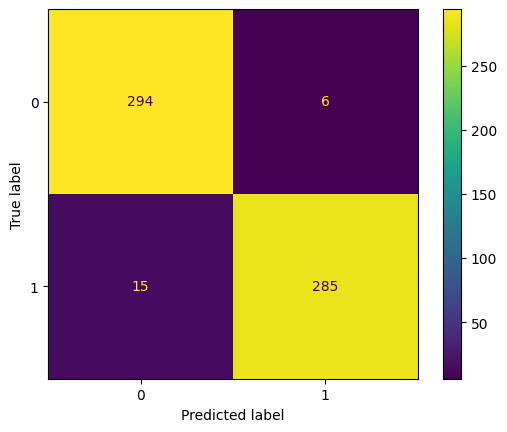

In [8]:
fig = ConfusionMatrixDisplay(confusion_matrix(test_y, test_y_pred))
fig.plot()
plt.show()

## Test Error

In [9]:
acc = accuracy_score(test_y, test_y_pred)
print(f'Test Error: {(1 - acc) * 100:.2f} %')

Test Error: 3.50 %
